# Leer datasets

In [35]:
import pandas as pd
import numpy as np

customer = pd.read_csv('../data/customer_data.csv')
#nos quedamos con 1000 datos aleatorios
customer = customer.sample(n=1000, random_state=42)
customer.head()

,id,age,gender,income,education,region,loyalty_status,purchase_frequency,purchase_amount,product_category,promotion_usage,satisfaction_score
75721,75722,19,Male,6378,Masters,South,Regular,rare,3024,Books,1,5
80184,80185,30,Female,20232,College,South,Silver,occasional,6721,Electronics,0,7
19864,19865,26,Male,11959,College,North,Silver,occasional,4868,Electronics,0,6
76699,76700,34,Female,18059,College,West,Regular,rare,7386,Electronics,0,4
92991,92992,31,Male,12968,College,North,Silver,rare,5024,Books,0,6


In [36]:
customer.drop(columns=['id'], inplace=True)
#pasar a numerico el gender
customer['gender'] = customer['gender'].map({'Male': 0, 'Female': 1})
#pasar a numerico el education ['Bachelor' 'Masters' 'HighSchool' 'College']
education_mapping = {
    'HighSchool': 0,
    'College': 1,
    'Bachelor': 2,
    'Masters': 3
}
customer['education'] = customer['education'].map(education_mapping)
#pasar purchase_frequency a numerico
purchase_frequency_mapping = {
    'rare': 0,
    'occasional': 1,
    'frequent': 2,
}
customer['purchase_frequency'] = customer['purchase_frequency'].map(purchase_frequency_mapping)
#dumificar el region ['North', 'South', 'East', 'West']
customer = pd.get_dummies(customer, columns=['region'], prefix='region', drop_first=True, dtype=int)
#dumificar product_category
customer = pd.get_dummies(customer, columns=['product_category'], prefix='product', drop_first=True, dtype=int)
#dumificar loyalty_status
customer = pd.get_dummies(customer, columns=['loyalty_status'], prefix='loyalty', drop_first=True, dtype=int)
customer.head()

,age,gender,income,education,purchase_frequency,purchase_amount,promotion_usage,satisfaction_score,region_North,region_South,region_West,product_Books,product_Clothing,product_Electronics,product_Food,product_Health,product_Home,loyalty_Regular,loyalty_Silver
75721,19,0,6378,3,0,3024,1,5,0,1,0,1,0,0,0,0,0,1,0
80184,30,1,20232,1,1,6721,0,7,0,1,0,0,0,1,0,0,0,0,1
19864,26,0,11959,1,1,4868,0,6,1,0,0,0,0,1,0,0,0,0,1
76699,34,1,18059,1,0,7386,0,4,0,0,1,0,0,1,0,0,0,1,0
92991,31,0,12968,1,0,5024,0,6,1,0,0,1,0,0,0,0,0,0,1


# Realizamos los clusters

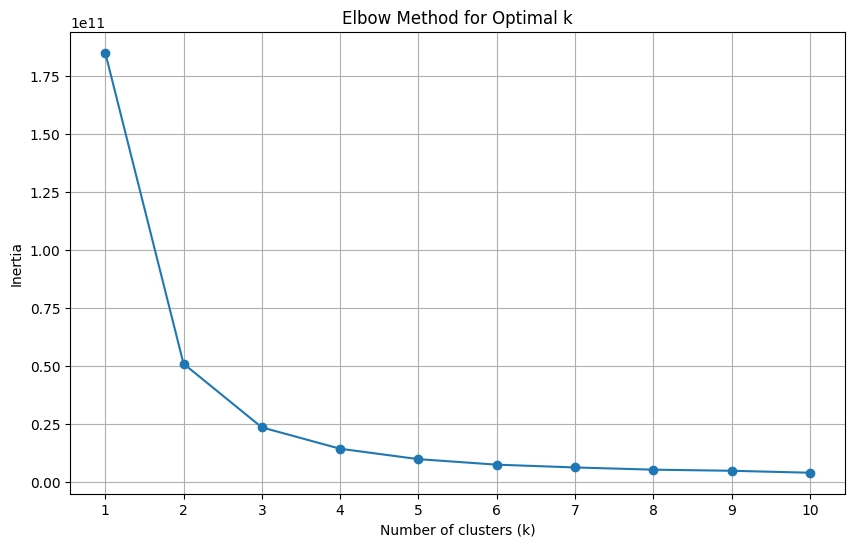

In [37]:
#hagamos metodo del codo para determinar el numero de clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def elbow_method(data, max_k=10):
    inertia = []
    k_values = range(1, max_k + 1)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertia, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_values)
    plt.grid()
    plt.show()
# Aplicar el método del codo
elbow_method(customer)

In [38]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(customer)
kmeans_labels = kmeans.labels_
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan.fit(customer)
dbscan_labels = dbscan.labels_
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(customer)
gmm_labels = gmm.predict(customer)

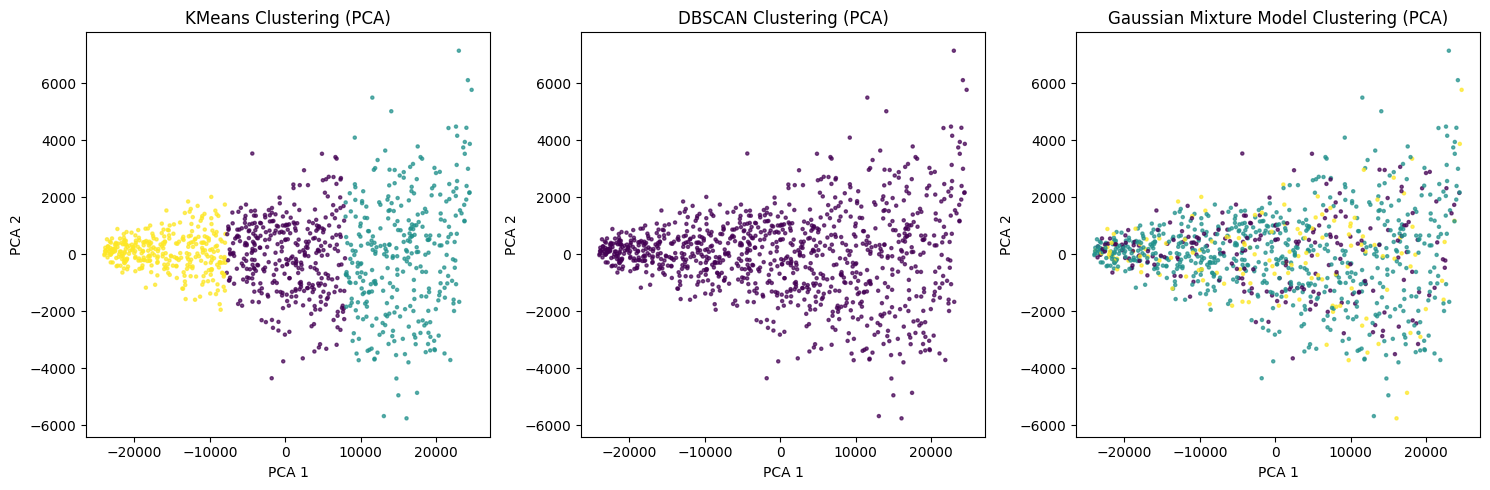

In [39]:
from sklearn.decomposition import PCA

# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2, random_state=42)
customer_pca = pca.fit_transform(customer)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(customer_pca[:, 0], customer_pca[:, 1], c=kmeans_labels, cmap='viridis', s=5, alpha=0.7)
plt.title('KMeans Clustering (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 3, 2)
plt.scatter(customer_pca[:, 0], customer_pca[:, 1], c=dbscan_labels, cmap='viridis', s=5, alpha=0.7)
plt.title('DBSCAN Clustering (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 3, 3)
plt.scatter(customer_pca[:, 0], customer_pca[:, 1], c=gmm_labels, cmap='viridis', s=5, alpha=0.7)
plt.title('Gaussian Mixture Model Clustering (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()

In [40]:
from sklearn.metrics import silhouette_score
kmeans_silhouette = silhouette_score(customer, kmeans_labels)
if dbscan_labels is not None and len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(customer, dbscan_labels[dbscan_labels != -1])  # Exclude noise points
else:
    dbscan_silhouette = -1
gmm_silhouette = silhouette_score(customer, gmm_labels)
print(f'KMeans Silhouette Score: {kmeans_silhouette:.2f}')
print(f'DBSCAN Silhouette Score: {dbscan_silhouette:.2f}')
print(f'Gaussian Mixture Model Silhouette Score: {gmm_silhouette:.2f}')

KMeans Silhouette Score: 0.56
DBSCAN Silhouette Score: -1.00
Gaussian Mixture Model Silhouette Score: -0.02


# Interpretar

In [41]:
import sys
sys.path.append('..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

## Kmeans

In [42]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(customer, kmeans_labels, test_size=0.2, random_state=42)


In [43]:
#muestrame los centros de los clusters
centers = kmeans.cluster_centers_
print("KMeans Cluster Centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

KMeans Cluster Centers:
Cluster 0: [2.97920228e+01 5.69800570e-01 2.79526410e+04 1.26780627e+00
 7.46438746e-01 9.74597721e+03 3.33333333e-01 4.99145299e+00
 1.82336182e-01 2.16524217e-01 2.67806268e-01 1.50997151e-01
 2.07977208e-01 2.79202279e-01 1.62393162e-01 1.08262108e-01
 4.27350427e-02 6.18233618e-01 2.73504274e-01]
Cluster 1: [2.99320988e+01 4.96913580e-01 4.23336852e+04 1.27160494e+00
 7.40740741e-01 1.49283395e+04 3.17901235e-01 5.03395062e+00
 2.46913580e-01 1.88271605e-01 2.80864198e-01 1.51234568e-01
 1.82098765e-01 2.99382716e-01 1.66666667e-01 1.11111111e-01
 4.62962963e-02 6.01851852e-01 3.14814815e-01]
Cluster 2: [3.01169231e+01 5.16923077e-01 1.26184954e+04 1.32923077e+00
 7.07692308e-01 4.40779385e+03 3.26153846e-01 5.10769231e+00
 1.90769231e-01 2.00000000e-01 3.04615385e-01 1.41538462e-01
 1.96923077e-01 3.13846154e-01 1.66153846e-01 9.23076923e-02
 4.92307692e-02 6.46153846e-01 2.76923077e-01]


In [44]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 0.92


In [45]:
ripper.print_rules()


Reglas para clase: 0
[[income=24009.4-28126.0] V [income=28126.0-32170.4] V [income=19480.1-24009.4^purchase_amount=8279.2-9647.5] V [income=32170.4-36608.6^purchase_frequency=0^satisfaction_score=4] V [income=32170.4-36608.6^purchase_amount=9647.5-10887.6] V [income=19480.1-24009.4^purchase_amount=6710.8-8279.2^region_South=0] V [income=32170.4-36608.6] V [income=19480.1-24009.4]]

Reglas para clase: 1
[[income=36608.6-40934.6] V [income=>45415.6] V [income=40934.6-45415.6] V [income=32170.4-36608.6^product_Food=1^satisfaction_score=6] V [income=32170.4-36608.6^loyalty_Regular=0^education=3] V [income=32170.4-36608.6^satisfaction_score=5^age=34.0-36.0] V [income=32170.4-36608.6^satisfaction_score=5^purchase_amount=14099.4-16338.6]]

Reglas para clase: 2
[[purchase_amount=<3249.8] V [purchase_amount=3249.8-5014.8] V [income=14747.8-19480.1] V [purchase_amount=5014.8-6710.8^income=9367.0-14747.8] V [income=19480.1-24009.4^purchase_amount=5014.8-6710.8]]


Decision Tree Accuracy: 0.97


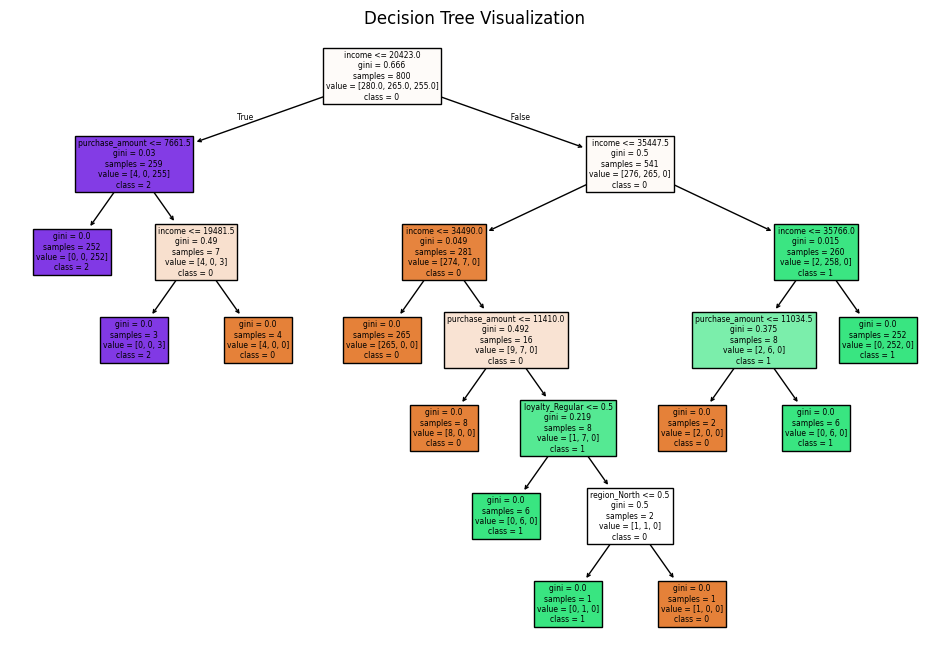

In [46]:
tree = DecisionTreeClassifier(random_state=44)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=customer.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [47]:
ds = DSClassifierMultiQ(3, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=customer.columns.tolist())


Optimization started

Training time: 49.35s, epochs: 200

Least training loss reached: 0.037


In [48]:
ds.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.721] R8: 27836.295 < income < 36488.967
			0: 0.721	1: 0.000	2: 0.000	Unc: 0.279

	[0.714] R7: 19183.623 < income < 27836.295
			0: 0.714	1: 0.000	2: 0.000	Unc: 0.286

	[0.698] R19: 9773.680 < purchase_amount < 13022.512
			0: 0.487	1: 0.513	2: 0.000	Unc: 0.000

	[0.641] R18: 6524.848 < purchase_amount < 9773.680
			0: 0.638	1: 0.000	2: 0.006	Unc: 0.356

Most important rules for class 1

	[0.757] R20: purchase_amount > 13022.512
			0: 0.000	1: 0.757	2: 0.000	Unc: 0.243

	[0.717] R9: income > 36488.967
			0: 0.000	1: 0.717	2: 0.000	Unc: 0.283

	[0.717] R19: 9773.680 < purchase_amount < 13022.512
			0: 0.487	1: 0.513	2: 0.000	Unc: 0.000

	[0.358] R44: product_Home = 1
			0: 0.000	1: 0.268	2: 0.211	Unc: 0.521

Most important rules for class 2

	[0.707] R17: purchase_amount < 6524.848
			0: 0.000	1: 0.000	2: 0.707	Unc: 0.293

	[0.674] R6: income < 19183.623
			0: 0.000	1: 0.000	2: 0.674	Unc: 0.326

	[0.340] R30: region_South = 1
			0: 0.000	1: 0.012	

In [49]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.92
